Accuracy: 0.9354587869362364

Classification Report:
                         precision    recall  f1-score   support

     Affordable Growth       0.85      0.83      0.84       245
Financial/Legal Center       0.73      0.74      0.73        84
       High Rent Urban       1.00      1.00      1.00       875
       Tech Growth Hub       0.71      0.76      0.73        82

              accuracy                           0.94      1286
             macro avg       0.82      0.83      0.83      1286
          weighted avg       0.94      0.94      0.94      1286



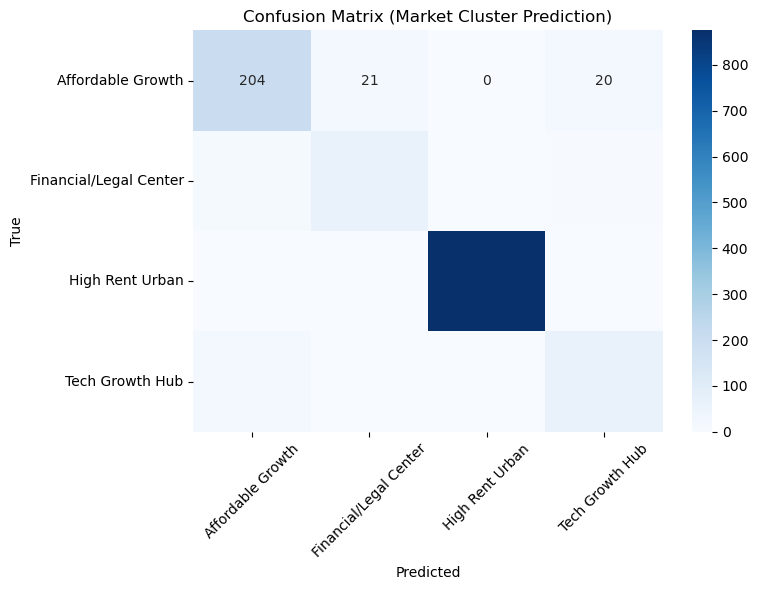

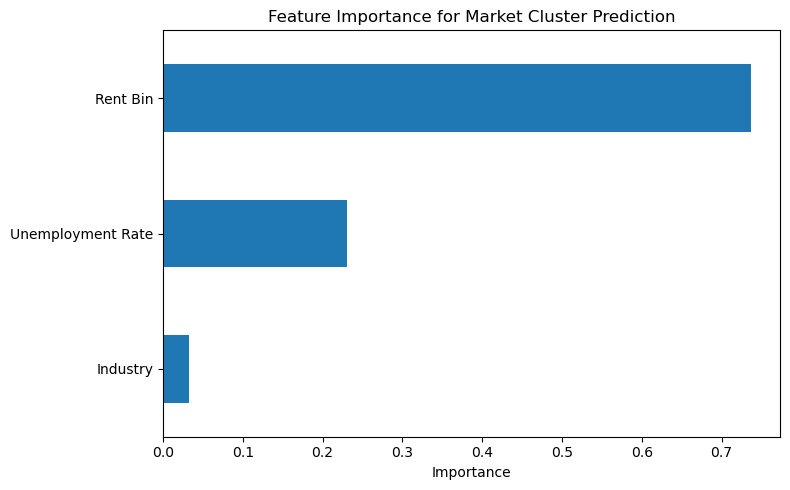

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load data
lease = pd.read_csv('lease_cleaned_final.csv')

# =====================
# Step 1: Create Cluster Labels
# =====================

# Map markets to clusters
market_cluster_map = {
    'Manhattan': 'High Rent Urban',
    'San Francisco': 'High Rent Urban',
    'Austin': 'Tech Growth Hub',
    'Dallas/Ft. Worth': 'Tech Growth Hub',
    'South Bay/San Jose': 'Tech Growth Hub',
    'Philadelphia': 'Financial/Legal Center',
    'Washington D.C.': 'Financial/Legal Center',
    'Chicago': 'Financial/Legal Center',
    'Houston': 'Affordable Growth',
    'Los Angeles': 'Affordable Growth'
}

# Create new column
lease['market_cluster'] = lease['market'].map(market_cluster_map)

# Drop any rows where market_cluster is missing (rare)
lease = lease.dropna(subset=['market_cluster'])

# =====================
# Step 2: Feature Engineering
# =====================

# Encode industry
le = LabelEncoder()
lease['industry_encoded'] = le.fit_transform(lease['internal_industry'])

# Optional: bin rent
lease['rent_bin'] = pd.cut(lease['overall_rent'],
                           bins=[0, 30, 50, 100],
                           labels=['Low', 'Medium', 'High'])

lease['rent_encoded'] = lease['rent_bin'].cat.codes

# Final features
features = lease[['industry_encoded', 'rent_encoded', 'unemployment_rate']]
target = lease['market_cluster']

# Drop missing
features = features.dropna()
target = target[features.index]

# Scale numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# =====================
# Step 3: Train-Test Split
# =====================

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)

# =====================
# Step 4: Random Forest Training
# =====================

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Market Cluster Prediction)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance
importances = model.feature_importances_
feature_names = ['Industry', 'Rent Bin', 'Unemployment Rate']

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title('Feature Importance for Market Cluster Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [2]:
# Define Cluster to Markets mapping
cluster_to_markets = {
    "tech growth hub": ["austin", "dallas/ft. worth", "south bay/san jose"],
    "high rent urban": ["manhattan", "san francisco"],
    "affordable growth": ["houston", "los angeles"],
    "financial/legal center": ["philadelphia", "washington d.c.", "chicago"]
}
# Predict Cluster based on sector, rent, unemployment
def recommend_market_cluster(sector, rent_budget, unemployment_rate):
    sector = sector.lower()
    if "technology" in sector or "media" in sector or "advertising" in sector:
        return "tech growth hub"
    elif "financial" in sector or "insurance" in sector:
        return "financial/legal center"
    elif "legal" in sector:
        return "high rent urban"
    else:
        return "affordable growth"


In [5]:
import pandas as pd

# Step 1: Load original lease file
lease_df = pd.read_csv('final_lease.csv')

# Step 2: Clean the important columns
lease_df['market'] = lease_df['market'].str.strip().str.lower()
lease_df['internal_submarket'] = lease_df['internal_submarket'].str.strip().str.lower()
lease_df['internal_class'] = lease_df['internal_class'].str.strip().str.upper()
lease_df['transaction_type'] = lease_df['transaction_type'].str.strip().str.lower()
lease_df['space_type'] = lease_df['space_type'].str.strip().str.lower()

# Step 3: Aggregate majority Internal Class, Transaction Type, Space Type by Market + Submarket
agg_majority = lease_df.groupby(['market', 'internal_submarket']).agg(
    majority_internal_class = ('internal_class', lambda x: x.value_counts().idxmax()),
    majority_transaction_type = ('transaction_type', lambda x: x.value_counts().idxmax()),
    majority_space_type = ('space_type', lambda x: x.value_counts().idxmax())
).reset_index()

# Step 4: Load submarket summary with leasing, rent, safety
top_submarkets_full = pd.read_csv('top_submarkets_with_safety_cleaned.csv')
top_submarkets_full['market'] = top_submarkets_full['market'].str.strip().str.lower()
top_submarkets_full['internal_submarket'] = top_submarkets_full['internal_submarket'].str.strip().str.lower()

# Step 5: Merge majority attributes
top_submarkets_final = pd.merge(top_submarkets_full, agg_majority, on=['market', 'internal_submarket'], how='left')

# Step 6: Save full clean dataset
top_submarkets_final.to_csv('top_submarkets_full_attributes.csv', index=False)

print("✅ Top Submarket Dataset updated with Internal Class, Transaction Type, Space Type!")


✅ Top Submarket Dataset updated with Internal Class, Transaction Type, Space Type!


In [6]:
# Step 7: Build Top Pick and Comparative Pick Table
def classify_submarkets(df):
    picks = []
    for city, group in df.groupby('market'):
        group_sorted = group.sort_values(by=['total_leased_sf', 'safety_rating', 'average_rent'], ascending=[False, False, True])
        
        top_pick = group_sorted.iloc[0]
        comparative_pick = group_sorted.iloc[-1]

        picks.append({
            'market': city,
            'top_submarket': top_pick['internal_submarket'],
            'top_leasing_sf': int(top_pick['total_leased_sf']),
            'top_rent': int(top_pick['average_rent']),
            'top_safety': top_pick['safety_rating'],
            'top_internal_class': top_pick['majority_internal_class'],
            'top_transaction_type': top_pick['majority_transaction_type'],
            'top_space_type': top_pick['majority_space_type'],
            'comparative_submarket': comparative_pick['internal_submarket'],
            'comp_leasing_sf': int(comparative_pick['total_leased_sf']),
            'comp_rent': int(comparative_pick['average_rent']),
            'comp_safety': comparative_pick['safety_rating'],
            'comp_internal_class': comparative_pick['majority_internal_class'],
            'comp_transaction_type': comparative_pick['majority_transaction_type'],
            'comp_space_type': comparative_pick['majority_space_type']
        })
        
    return pd.DataFrame(picks)

# Apply
submarket_recommendations_full = classify_submarkets(top_submarkets_final)

# Save
submarket_recommendations_full.to_csv('final_submarket_recommendations_full.csv', index=False)

print("✅ Top Pick and Comparative Pick classified with full attributes!")


✅ Top Pick and Comparative Pick classified with full attributes!


In [7]:
# Install prettytable if not installed
# pip install prettytable
from prettytable import PrettyTable

def business_recommendation_final(sector, rent_budget, unemployment_rate):
    # Predict Cluster
    cluster = recommend_market_cluster(sector, rent_budget, unemployment_rate)
    
    # Step 1: Select best city logically
    cities = cluster_to_markets.get(cluster.lower(), ["City data unavailable"])
    
    if cities == ["City data unavailable"]:
        print("\n No cities available for this cluster.")
        return
    
    # Get city scores
    candidate_city_data = top_submarkets_final[top_submarkets_final['market'].isin(cities)].groupby('market').agg({
        'total_leased_sf': 'sum',
        'average_rent': 'mean',
        'safety_rating': 'mean'
    }).reset_index()
    
    candidate_city_data['leasing_score'] = candidate_city_data['total_leased_sf'] / candidate_city_data['total_leased_sf'].max()
    candidate_city_data['safety_score'] = candidate_city_data['safety_rating'] / 5
    candidate_city_data['rent_score'] = 1 - (candidate_city_data['average_rent'] / candidate_city_data['average_rent'].max())
    candidate_city_data['final_score'] = candidate_city_data['leasing_score'] + candidate_city_data['safety_score'] + candidate_city_data['rent_score']
    
    chosen_city = candidate_city_data.sort_values(by='final_score', ascending=False).iloc[0]['market']
    
    # Step 2: Select top and comparative submarkets
    top_info = submarket_recommendations_full[submarket_recommendations_full['market'] == chosen_city]
    
    if not top_info.empty:
        top_row = top_info.iloc[0]
    else:
        print("\n❌ No submarket info available for this city.")
        return
    
    # Step 3: Final Clean PrettyTable
    table = PrettyTable()
    
    table.field_names = ["Attribute", "Top Submarket", "Comparative Submarket"]
    table.align = "l"  # Align left
    
    table.add_row(["Submarket", top_row['top_submarket'].title(), top_row['comparative_submarket'].title()])
    table.add_row(["Leasing Volume", f"{top_row['top_leasing_sf']} SF", f"{top_row['comp_leasing_sf']} SF"])
    table.add_row(["Average Rent", f"${top_row['top_rent']}/SF", f"${top_row['comp_rent']}/SF"])
    table.add_row(["Safety Rating", f"{top_row['top_safety']}", f"{top_row['comp_safety']}"])
    table.add_row(["Internal Class", f"{top_row['top_internal_class']}", f"{top_row['comp_internal_class']}"])
    table.add_row(["Transaction Type", f"{top_row['top_transaction_type'].title()}", f"{top_row['comp_transaction_type'].title()}"])
    table.add_row(["Space Type", f"{top_row['top_space_type'].title()}", f"{top_row['comp_space_type'].title()}"])
    
    # Step 4: Print nicely
    print("\n📣 Business Leasing Recommendation\n")
    print(f"✅ Sector: {sector}")
    print(f"✅ Budget: ${rent_budget}/SF")
    print(f"✅ Unemployment Tolerance: {unemployment_rate}%")
    print(f"✅ Recommended Cluster: {cluster.title()}")
    print(f"✅ Best City: {chosen_city.title()}\n")
    print(table)

# Example Usage
business_recommendation_final('Technology, Advertising, Media, and Information', 42, 3.5)


📣 Business Leasing Recommendation

✅ Sector: Technology, Advertising, Media, and Information
✅ Budget: $42/SF
✅ Unemployment Tolerance: 3.5%
✅ Recommended Cluster: Tech Growth Hub
✅ Best City: Austin

+------------------+---------------+-----------------------+
| Attribute        | Top Submarket | Comparative Submarket |
+------------------+---------------+-----------------------+
| Submarket        | Cbd           | Southwest             |
| Leasing Volume   | 5964921 SF    | 2486598 SF            |
| Average Rent     | $44/SF        | $44/SF                |
| Safety Rating    | 4.0           | 4.0                   |
| Internal Class   | A             | A                     |
| Transaction Type | New           | New                   |
| Space Type       | Relet         | Relet                 |
+------------------+---------------+-----------------------+


In [8]:
business_recommendation_final('Financial Services and Insurance', 58, 4.2)

business_recommendation_final('Legal Services', 36, 4.5)

business_recommendation_final('Technology, Advertising, Media, and Information', 40, 3.7)

business_recommendation_final('Technology, Advertising, Media, and Information', 18, 4.0)



📣 Business Leasing Recommendation

✅ Sector: Financial Services and Insurance
✅ Budget: $58/SF
✅ Unemployment Tolerance: 4.2%
✅ Recommended Cluster: Financial/Legal Center
✅ Best City: Philadelphia

+------------------+---------------+------------------------+
| Attribute        | Top Submarket | Comparative Submarket  |
+------------------+---------------+------------------------+
| Submarket        | West Market   | Media / Newtown Square |
| Leasing Volume   | 5321646 SF    | 999000 SF              |
| Average Rent     | $30/SF        | $30/SF                 |
| Safety Rating    | nan           | nan                    |
| Internal Class   | A             | A                      |
| Transaction Type | New           | New                    |
| Space Type       | Unknown       | Relet                  |
+------------------+---------------+------------------------+

📣 Business Leasing Recommendation

✅ Sector: Legal Services
✅ Budget: $36/SF
✅ Unemployment Tolerance: 4.5%
✅ Recomme

In [21]:
import pandas as pd


# Step 1: Load and clean leasing data
lease_df = pd.read_csv('final_lease.csv')
lease_df.columns = lease_df.columns.str.strip().str.lower()
lease_df['cbd_suburban'] = lease_df['cbd_suburban'].str.strip().str.lower()
lease_df['internal_class'] = lease_df['internal_class'].str.strip().str.lower()
lease_df['year'] = lease_df['year'].astype(int)

# Step 2: Focus on post-COVID years (2020 onwards)
lease_df = lease_df[lease_df['year'] >= 2020]

# Step 3: Aggregate rent and average lease size by Market, Submarket, Class, Location
match_table = lease_df.groupby(['market', 'internal_submarket', 'internal_class', 'cbd_suburban']).agg(
    avg_rent=('overall_rent', 'mean'),
    avg_size=('leasedsf', 'mean')
).reset_index()

 
from prettytable import PrettyTable

# Step 1: Create a PrettyTable
pretty_matches = PrettyTable()

# Step 2: Define column names
pretty_matches.field_names = ["Market", "Submarket", "Class", "Avg Rent ($/sf)", "Avg Size (sf)"]
print(pretty_matches)

# Step 2: Filter based on their preferences
tech_startup_matches = match_table[
    (match_table['avg_rent'] <= budget) &
    (match_table['internal_class'] == preferred_class) &
    (match_table['cbd_suburban'] == preferred_location) &
    (match_table['avg_size'] >= min_size) &
    (match_table['avg_size'] <= max_size)
]

tech_startup_matches = tech_startup_matches.sort_values('avg_rent')
for _, row in tech_startup_matches.iterrows():
    pretty_matches.add_row([
        row['market'].title(),  # capitalize for clean format
        row['internal_submarket'].title(),
        row['internal_class'].upper(),
        f"{row['avg_rent']:.2f}",
        f"{int(row['avg_size'])}"
    ])

tech_startup_matches = match_table[
    (match_table['avg_rent'] <= budget) &
    (match_table['internal_class'] == preferred_class) &
    (match_table['cbd_suburban'] == preferred_location) &
    (match_table['avg_size'] >= min_size) &
    (match_table['avg_size'] <= max_size)
]



+--------+-----------+-------+-----------------+---------------+
| Market | Submarket | Class | Avg Rent ($/sf) | Avg Size (sf) |
+--------+-----------+-------+-----------------+---------------+
+--------+-----------+-------+-----------------+---------------+


In [22]:
from prettytable import PrettyTable

def smart_match_client(match_table, budget, preferred_class, preferred_location, target_size, flexibility=True):
    # Step 1: Relax Budget and Size if flexibility allowed
    if flexibility:
        relaxed_budget = budget * 1.10  # allow 10% more budget
        min_size = target_size * 0.8    # allow 20% smaller
        max_size = target_size * 1.2    # allow 20% bigger
    else:
        relaxed_budget = budget
        min_size = target_size * 0.9
        max_size = target_size * 1.1

    # Step 2: Filter basic rent and size
    matches = match_table[
        (match_table['avg_rent'] <= relaxed_budget) &
        (match_table['avg_size'] >= min_size) &
        (match_table['avg_size'] <= max_size)
    ]

    # Step 3: Prefer matching class first
    matches_class = matches[matches['internal_class'] == preferred_class]

    # Step 4: Prefer matching location next
    matches_location = matches_class[matches_class['cbd_suburban'] == preferred_location]

    if not matches_location.empty:
        final_matches = matches_location
    elif not matches_class.empty:
        final_matches = matches_class
    elif flexibility:
        # Try fallback: allow Class B if no Class A
        fallback_class = 'b' if preferred_class == 'a' else 'c'
        matches_fallback_class = matches[matches['internal_class'] == fallback_class]
        matches_fallback_location = matches_fallback_class[matches_fallback_class['cbd_suburban'] == preferred_location]
        if not matches_fallback_location.empty:
            final_matches = matches_fallback_location
        elif not matches_fallback_class.empty:
            final_matches = matches_fallback_class
        else:
            final_matches = pd.DataFrame()
    else:
        final_matches = pd.DataFrame()

    # Step 5: Display result
    if final_matches.empty:
        print("❌ No matching options found even after smart relaxation.")
        return None

    # Step 6: Pretty Table Output
    table = PrettyTable()
    table.field_names = ["Market", "Submarket", "Class", "Location", "Avg Rent ($/sf)", "Avg Size (sf)"]

    for _, row in final_matches.sort_values('avg_rent').iterrows():
        table.add_row([
            row['market'].title(),
            row['internal_submarket'].title(),
            row['internal_class'].upper(),
            row['cbd_suburban'].title(),
            f"{row['avg_rent']:.2f}",
            f"{int(row['avg_size'])}"
        ])

    return table


In [23]:
print(smart_match_client(
    match_table,
    budget=40,
    preferred_class='a',
    preferred_location='suburban',
    target_size=20000
))


+---------------------+------------------------------------------+-------+----------+-----------------+---------------+
|        Market       |                Submarket                 | Class | Location | Avg Rent ($/sf) | Avg Size (sf) |
+---------------------+------------------------------------------+-------+----------+-----------------+---------------+
|       Detroit       |                Southfield                |   A   | Suburban |      20.87      |     22125     |
|       Detroit       |                Bloomfield                |   A   | Suburban |      20.96      |     21826     |
|       Detroit       |                Troy South                |   A   | Suburban |      21.03      |     18556     |
|       Detroit       |             Pontiac / Lakes              |   A   | Suburban |      21.12      |     23811     |
|      Baltimore      |            Route 83 Corridor             |   A   | Suburban |      24.19      |     22595     |
|      Baltimore      |         Reisters

In [24]:
print(match_client_to_options(
    match_table,
    budget=40,
    preferred_class='a',
    preferred_location='suburban',
    min_size=18000,
    max_size=25000
))

# For Law Firm B
print(match_client_to_options(
    match_table,
    budget=55,
    preferred_class='a',
    preferred_location='cbd',
    min_size=12000,
    max_size=18000
))

# For FinTech Company C (coming next!)
print(match_client_to_options(
    match_table,
    budget=45,
    preferred_class='a',  # but we will make it flexible later
    preferred_location='cbd',  # or suburban if needed
    min_size=18000,
    max_size=20000
))

NameError: name 'match_client_to_options' is not defined